In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tools
from imp import reload
reload(tools)
from tools import syn_registration
%matplotlib inline

import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
import dipy.data as dpd

In [19]:
import nibabel as nib
import dipy.data as dpd
import os

In [18]:
afqpath = '/home/jyeatman/git/afq'

In [3]:
ni, gtab = dpd.read_stanford_hardi()

In [4]:
hardi_data = ni.get_data()
hardi_affine = ni.get_affine()

In [5]:
b0 = hardi_data[..., gtab.b0s_mask]

In [6]:
mean_b0 = np.mean(b0, -1)

In [7]:
ni_b0 = nib.Nifti1Image(mean_b0, hardi_affine)

In [8]:
ni_b0.to_filename('mean_b0.nii')

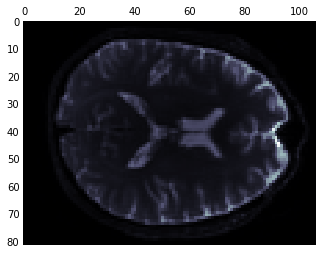

In [9]:
plt.matshow(mean_b0[:,:,mean_b0.shape[-1]//2], cmap=cm.bone)

In [11]:
MNI_T2 = nib.load('/home/jyeatman/git/afq/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t2_tal_nlin_asym_09a.nii')

In [12]:
MNI_T2_data = MNI_T2.get_data()

In [13]:
MNI_T2_affine = MNI_T2.get_affine()

In [14]:
warped_b0, mapping = syn_registration(mean_b0, MNI_T2_data, moving_grid2world=hardi_affine, static_grid2world=MNI_T2_affine, 
                                      metric='CC', dim=3, level_iters = [10, 10, 5], prealign=None)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


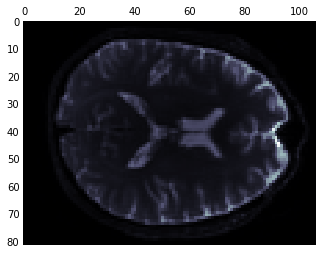

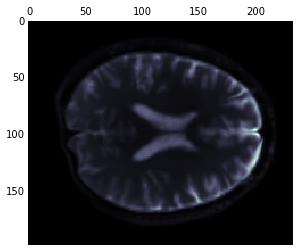

In [15]:
plt.matshow(mean_b0[:,:,mean_b0.shape[-1]//2], cmap=cm.bone)
plt.matshow(warped_b0[:,:,warped_b0.shape[-1]//2], cmap=cm.bone)

In [16]:
new_ni = nib.Nifti1Image(warped_b0, MNI_T2_affine)

In [17]:
new_ni.to_filename('./warped_b0.nii.gz')

In [22]:
LOCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/L_Occipital.nii.gz'))
ROCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/R_Occipital.nii.gz'))
midsag_ni = nib.load(os.path.join(afqpath,'templates/callosum2/Callosum_midsag.nii.gz'))

In [23]:
LOCC_data = LOCC_ni.get_data()
ROCC_data = ROCC_ni.get_data()
midsag_data = midsag_ni.get_data()

In [24]:
midsag_affine = midsag_ni.get_affine()

In [25]:
midsag_data = midsag_ni.get_data()

In [26]:
warped_midsag = mapping.transform_inverse(midsag_data)

In [27]:
#bin_warped_LOCC = np.ceil(warped_LOCC)
bin_warped_midsag = np.ceil(warped_midsag)

In [28]:
im = np.sum(np.ceil(bin_warped_midsag), axis=0)

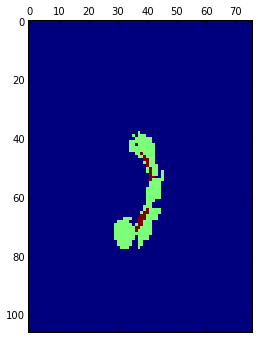

In [29]:
plt.matshow(im)

In [30]:
import scipy.ndimage as ndim

In [73]:
#filled_warped_LOCC= ndim.binary_dilation(bin_warped_LOCC, iterations=1).astype(int)
filled_warped_midsag= ndim.binary_fill_holes(bin_warped_midsag.astype(int)).astype(int)

In [32]:
np.unique(filled_warped_midsag)

array([0, 1])

In [33]:
filled_warped_midsag_ni = nib.Nifti1Image(filled_warped_midsag, hardi_affine)

In [34]:
filled_warped_midsag_ni.to_filename('./warped_midsag.nii.gz')

In [35]:
im = np.sum(np.ceil(ndim.binary_fill_holes(filled_warped_midsag)), axis=0)

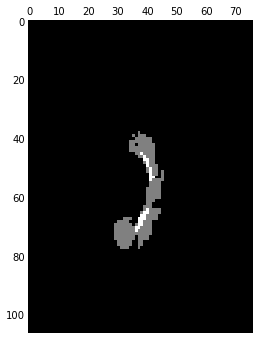

In [36]:
plt.matshow(im, cmap=cm.gray)

In [37]:
sl_from_file = nib.trackvis.read('./tensor_streamlines.trk', points_space='rasmm')

In [38]:
all_sl = [s[0] for s in sl_from_file[0]]

In [39]:
len(sl_from_file)

2

In [40]:
xform_sl = [s for s in dtu.move_streamlines(all_sl, np.linalg.inv(hardi_affine))]

In [41]:
select_sl = dts.select_by_roi(xform_sl, [warped_midsag.astype(bool)], [True], 
                              affine=np.linalg.inv(filled_warped_midsag_ni.get_affine()))

In [42]:
t0 = time.time()
select_sl = [s for s in select_sl]
t1 = time.time()
print(t1 - t0)

141.842154026


In [43]:
len(select_sl)

41230

In [47]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

In [48]:
ren = fvtk.ren()
fvtk.add(ren, fvtk.streamtube(select_sl, line_colors(select_sl)))
#fvtk.record(ren, n_frames=1, out_path='callosal_tracks.png', size=(600, 600))
fvtk.show(ren)

In [ ]:
import IPython.display as display

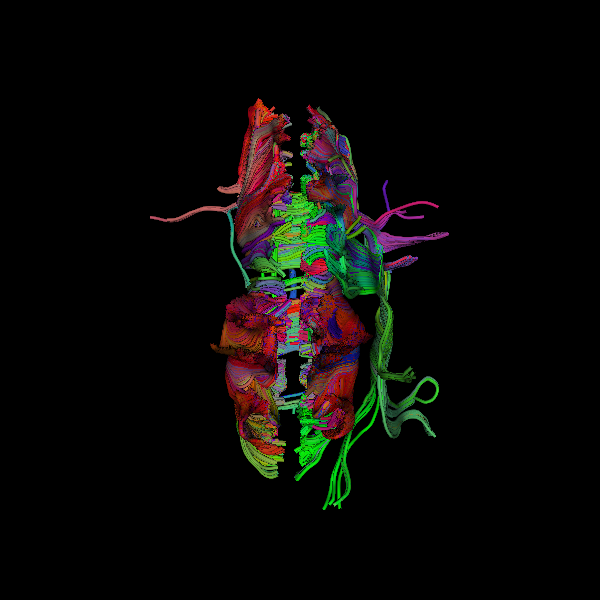

In [45]:
display.Image(filename='callosal_tracks.png')

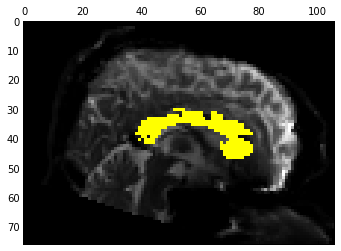

In [108]:
newarray = filled_warped_midsag.astype(float)
newarray = np.sum(newarray,0)
newarray[newarray==0]=np.nan
fig,ax = plt.subplots(1)
ax.matshow(np.rot90(mean_b0[40,:,:]),cmap=cm.gray, vmin=100, vmax = 5000)
ax.matshow(np.rot90(newarray), cmap=cm.autumn, vmin=0, vmax = 1)